## Linear classification
    - 102 epochs initial (kmeans)
    - 200 additional epochs (kmeans)
    - train data:
    
```
Haus8 sgRNA #1	190219_195942-V	B12	
Haus8 sgRNA #2	190219_195942-V	E1	
Haus8 sgRNA #3	190219_195942-V	F2	
Haus8 sgRNA #4	190219_195942-V	G2	
DyncH1 sgRNA #3	190219_195942-V	A1	
Incenp sgRNA #1	190219_195942-V	G4	
Incenp sgRNA #2	190219_195942-V	G6	
Incenp sgRNA #3	190219_195942-V	H1	
Rad21 sgRNA #1	190219_195942-V	H3	
Rad21 sgRNA #2	190219_195942-V	H5	
Rad21 sgRNA #3	190219_195942-V	H7
```
Classifier was then built on curated data with train/val/test split = 0.7/0.2/0.1.  


In [1]:
import time
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable
from util import load_model
from util import AverageMeter, Logger, UnifLabelSampler
import seaborn as sn
import pandas as pd
from glob import glob
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import cv2

In [2]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

### Import data

In [3]:
data_dir = '/home/aogorodnikov/test'

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
tra = [transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       normalize]
dataset = ImageFolderWithPaths(data_dir, transform=transforms.Compose(tra))
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=256,
                                         num_workers=8,
                                         shuffle=True,
                                         pin_memory=True)

len(dataset)

2880

### Import model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model=load_model('/home/aogorodnikov/kmeans100_linear_classif_imagenet/model_best.pth.tar')
# freeze some layers
for param in model.features.parameters():
    param.requires_grad = False
    
criterion = nn.CrossEntropyLoss().cuda()

=> loading checkpoint '/home/aogorodnikov/kmeans100_linear_classif_imagenet/model_best.pth.tar'
Loaded


In [6]:
model.cuda()
model


AlexNet(
  (features): Sequential(
    (0): Conv2d(2, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): Conv2d(384, 256, kernel_si

### Test function

In [7]:
def test(model, criterion):
# monitor test loss and accuracy
    image = []
    ground = []
    pred_class = []
    running_loss = 0.
    running_corrects = 0.
    total = 0.
    with torch.no_grad():
        for batch_idx, (data, labels, path) in enumerate(dataloader):
            # move to GPU
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            # statistics
            running_loss += loss.item() * data.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += data.size(0)
            
            image.extend(path)
            ground.extend(labels.tolist())
            pred_class.extend(preds.tolist())
            
    tot_loss = running_loss / len(dataset)
    tot_acc = running_corrects.double() / len(dataset)
            
    print('Test Loss: {:.6f}\n'.format(tot_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * tot_acc, running_corrects, total))
    return [image, ground, pred_class]

In [8]:
%%time
lol = test(model, criterion)

Test Loss: 0.245740


Test Accuracy: 92% (2677/2880)


### Visualization of labels and precitions

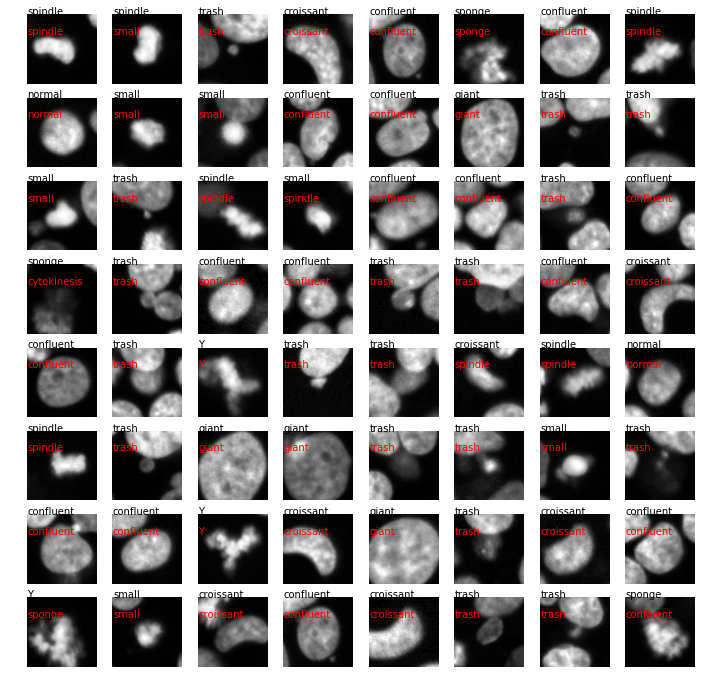

In [11]:
fig=plt.figure(figsize=(12, 12))
columns = 8
rows = 8
for k in range(1, columns * rows + 1):
    rand_select = np.random.choice(range(1, len(lol[0])))
    img_plot = lol[0][rand_select]
    img_import = cv2.imread(img_plot, -1)
    fig.add_subplot(rows, columns, k)
    plt.imshow(img_import, cmap='gray');
    plt.axis('off')
    plt.text(0, 0, s=dataset.classes[lol[1][rand_select]])
    plt.text(0, 20, s=dataset.classes[lol[2][rand_select]], color='red')
    plt.axis('off')
plt.show()

In [10]:
type(dataset.classes)

list

In [66]:
with open('/home/aogorodnikov/classes.txt', 'w') as f:
    for item in dataset.classes:
        f.write("%s\n" % item)